## Lab 7 FB-33 Rudyi Artem

In [43]:
!gdalinfo --version
import os
from sentinelhub import SHConfig
from sentinelhub.aws import request
import zipfile
import subprocess
import shutil
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from tqdm import tqdm
import numpy as np










GDAL 3.10.0, released 2024/11/01


In [41]:
!pip install numpy

1. Завантажити необхідні дані Sentinel-2 (або з Copernicus SciHub, або з
Google-диска). За допомогою бібліотеки sentinelhub написати скрипт для
завантаження супутникових знімків Sentinel-2, які покривають Київ (ROI — POLYGON((29.073321247506765 49.845775018245774,31.986007792928522
49.845775018245774,31.986007792928522 51.278667808079206,29.073321247506765
51.278667808079206,29.073321247506765 49.845775018245774)) )
   
Список ідентифікаторів Sentinel-2:

– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T11
5206

– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T11
5206

In [ ]:

data_dir = os.path.join(os.getcwd(), "data")
os.makedirs(data_dir, exist_ok=True)


# config = SHConfig()
# config.aws_access_key_id = 'secret'
# config.aws_secret_access_key = 'secret'
# config.save()



def download_sentinel_data(product_id: str):
    try:
        print(f"Завантаження продукту {product_id}...")
        request.download_safe_format(
            product_id,
            folder=data_dir,
            redownload=False,
            data_collection='sentinel-s2-l2a'
        )
        print(f"Продукт {product_id} успішно завантажено.")
    except Exception as e:
        print(f"Помилка під час завантаження продукту {product_id}: {e}")



product_ids = [
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206"
]

for product_id in product_ids:
    download_sentinel_data(product_id)


 Засобами командного рядка операційної системи (демонстраційні приклади розглянуті для ОС Windows), а також за допомогою бінаріїв бібліотеки GDAL розробити автоматичний сценарій, який здійснюватиме обробку даних ДЗЗ, відповідно до поставлених завдань. Для виконання команд gdal у сценарії Python можна використовувати бібліотеки os та command.

1. Розпакування наборів архівів з продуктами ДЗЗ в новостворені папки,
назви яких відповідатимуть ідентифікаторам зображень.

In [26]:
def extract_archives_to_named_folders(folder_path):
    archive_extensions = ('.zip',)
    archives = [f for f in os.listdir(folder_path) if f.lower().endswith(archive_extensions)]

    
    if not archives:
        print("Архіви не знайдені. Перевірка папок з .SAFE буде виконана.")

    for archive in archives:
        archive_path = os.path.join(folder_path, archive)
        product_id = os.path.splitext(archive)[0]
        extract_to = os.path.join(folder_path, product_id)

        if not os.path.exists(extract_to):
            os.makedirs(extract_to)

        print(f"Розпаковується: {archive} -> {extract_to}")
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Успішно розпаковано в {extract_to}")

    
    for folder in os.listdir(folder_path):
        safe_folder = os.path.join(folder_path, folder)
        if os.path.isdir(safe_folder) and folder.lower().endswith(".safe"):
            new_folder_name = os.path.join(folder_path, folder[:-10])  
            if not os.path.exists(new_folder_name):
                shutil.move(safe_folder, new_folder_name)  
                print(f"Папка {safe_folder} перейменована в {new_folder_name}")


extract_archives_to_named_folders("/home/arten/Desktop/lab7/data")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/arten/Desktop/lab7/data'

2. Конкатенація каналів видимого, ближнього та середнього
інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в
єдиний GEOTIFF файл.

In [25]:
path_A = "/home/arten/Desktop/lab7/data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T1/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R10m"
path_B = "/home/arten/Desktop/lab7/data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T1/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R10m"

channels_B = [
    "T36UUB_20190821T085601_B02_10m.jp2",
    "T36UUB_20190821T085601_B03_10m.jp2",
    "T36UUB_20190821T085601_B04_10m.jp2",
    "T36UUB_20190821T085601_B08_10m.jp2"
]

channels_A = [
    "T36UUA_20190821T085601_B02_10m.jp2",
    "T36UUA_20190821T085601_B03_10m.jp2",
    "T36UUA_20190821T085601_B04_10m.jp2",
    "T36UUA_20190821T085601_B08_10m.jp2"
]


input_files_A = [
    os.path.join(path_A, channel) for channel in channels_A
]

input_files_B = [
    os.path.join(path_B, channel) for channel in channels_B
]


output_path_A = "/home/arten/Desktop/lab7/data/merged_T36UUA.tif"
output_path_B = "/home/arten/Desktop/lab7/data/merged_T36UUB.tif"


command_A = [
    "/usr/bin/gdal_merge.py",  
    "-separate",
    "-o", output_path_A
] + input_files_A


command_B = [
    "/usr/bin/gdal_merge.py",  
    "-separate",
    "-o", output_path_B
] + input_files_B


subprocess.run(command_A, check=True)
subprocess.run(command_B, check=True)

print(f"A збережено як {output_path_A}")
print(f"B збережено як {output_path_B}")

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [45]:
def display_tif_images(directory, cmap='inferno'):
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return
    
    
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            filepath = os.path.join(directory, filename)
            
            
            with rasterio.open(filepath) as dataset:
                print(f"Displaying {filename}")
                fig, ax = plt.subplots(figsize=(10, 8))
                img = show(dataset, ax=ax, cmap=cmap)
                
                
                ax.set_title(f"TIF Image: {filename}")
                
                plt.show() 


Displaying merged_T36UUA.tif


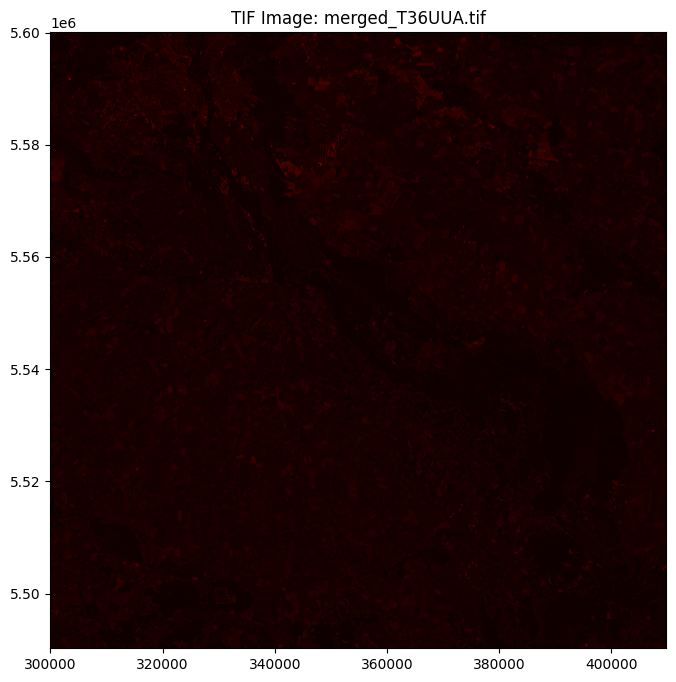

Displaying merged_T36UUB.tif


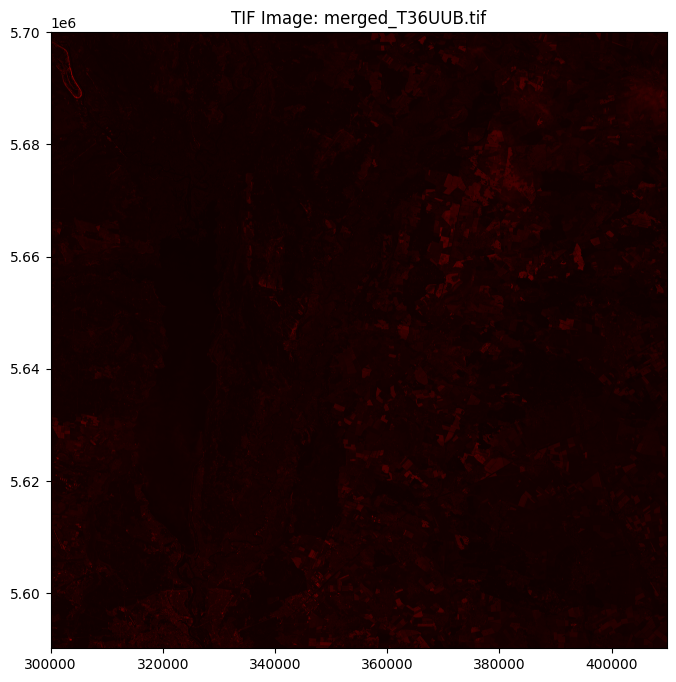

In [28]:
directory_path = 'data'

display_tif_images(directory_path, cmap='hot')


2. Перепроектування супутникового зображення у проєкцію 4326.

In [32]:
def reproject_tiff(input_path, output_path=None, target_epsg="EPSG:4326"):
    if not output_path:
        base, ext = os.path.splitext(input_path)
        output_path = f"{base}_reproj{ext}"
    
    try:
        subprocess.run([
            "gdalwarp",
            "-t_srs", target_epsg,
            input_path,
            output_path
        ], check=True)
        print(f"Файл перепроектовано та збережено як: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"Помилка перепроектування: {e}")


reproject_tiff("/home/arten/Desktop/lab7/data/tif/merged_T36UUA.tif")

Помилка перепроектування: Command '['gdalwarp', '-t_srs', 'EPSG:4326', '/home/arten/Desktop/lab7/data/tif/merged_T36UUA.tif', '/home/arten/Desktop/lab7/data/tif/merged_T36UUA_reproj.tif']' returned non-zero exit status 1.


Displaying merged_T36UUA_reproj.tif


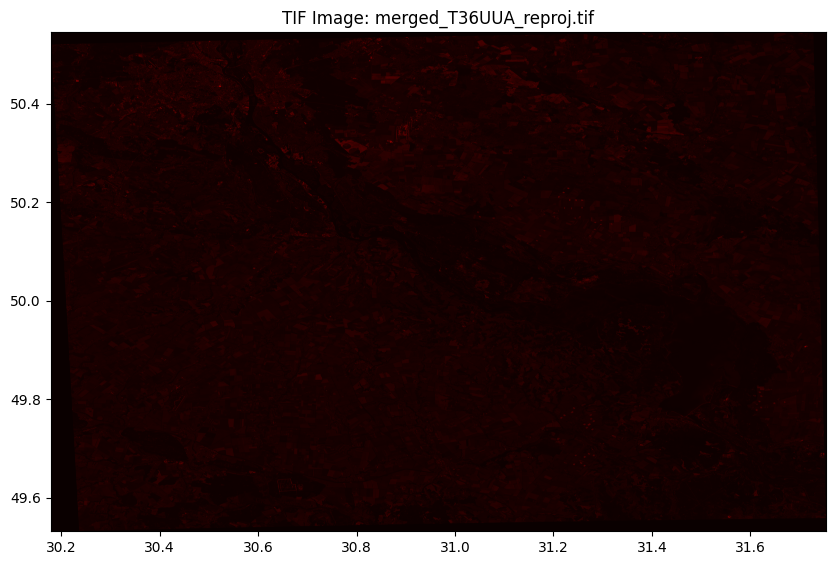

In [33]:
directory_path = 'data/4326'

display_tif_images(directory_path, cmap='hot')

3.Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

In [34]:
def merge_rasters_with_gdal(input_files, output_file):
    command = ['gdal_merge.py', '-separate', '-o', output_file] + input_files
    
    try:
        subprocess.run(command, check=True)
        print(f"Збережено в {output_file}")
    except subprocess.CalledProcessError as e:
        print(f"Помилка: {e}")


input_files = [
    '/home/arten/Desktop/lab7/data/tif/merged_T36UUA_reproj.tif',
    '/home/arten/Desktop/lab7/data/tif/merged_T36UUB_reproj.tif',
    
]

output_file = '/home/arten/Desktop/lab7/data/tif/output_merged.tif'

merge_rasters_with_gdal(input_files, output_file)

OSError: [WinError 193] %1 is not a valid Win32 application

In [ ]:
input_files = [
    '/home/arten/Desktop/lab7/data/tif/merged_T36UUB.tif',
    '/home/arten/Desktop/lab7/data/tif/merged_T36UUA.tif',
    
]
output_file = '/home/arten/Desktop/lab7/data/tif/output_merged2.tif'
merge_rasters_with_gdal(input_files, output_file)

In [ ]:
directory_path = 'data/clip'

display_tif_images(directory_path, cmap='hot')

4. Обрізання результуючого зображення по заданому векторному контуру.

In [ ]:
def POLYGON_convert(directory):
    fieldCoordinatesAsTextInWKTInEPSG4326 = "POLYGON((29.073321247506765 49.845775018245774, " \
        "31.986007792928522 49.845775018245774, " \
        "31.986007792928522 51.278667808079206, " \
        "29.073321247506765 51.278667808079206, " \
        "29.073321247506765 49.845775018245774))"
    
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    
    f_shp = os.path.join(directory, "Kyiv_regions.shp")
    
    gdf = gpd.GeoDataFrame(geometry=[shapely.wkt.loads(fieldCoordinatesAsTextInWKTInEPSG4326)])
    gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
    
    gdf.to_file(f_shp)
    print(f"Було створено .SHP файл за шляхом: {f_shp}")

directory_path = "/home/arten/Desktop/lab7/data/tif"
POLYGON_convert(directory_path)

In [ ]:
def crop_raster_with_cutline(input_raster, cutline_shapefile):
    if not os.path.exists(input_raster):
        print(f"Помилка: Растровий файл {input_raster} не знайдено.")
        return
    
    if not os.path.exists(cutline_shapefile):
        print(f"Помилка: Shapefile {cutline_shapefile} не знайдено.")
        return
    
    base_name = os.path.splitext(os.path.basename(input_raster))[0]
    output_raster = os.path.join(os.path.dirname(input_raster), f"{base_name}_clipped.tif")

    command = [
        'gdalwarp', 
        '-cutline', cutline_shapefile, 
        '-crop_to_cutline', 
        input_raster, 
        output_raster
    ]
    

    try:
        subprocess.run(command, check=True)
        print(f"Raster cropped successfully and saved to {output_raster}")
    except subprocess.CalledProcessError as e:
        print(f"Error during raster cropping: {e}")


input_raster = '/home/arten/Desktop/lab7/data/tif/merged_T36UUB.tif'
cutline_shapefile = '/home/arten/Desktop/lab7/data/tif/Kyiv_regions.shp'

crop_raster_with_cutline(input_raster, cutline_shapefile)

Displaying merged_T36UUB_clipped.tif


MemoryError: Unable to allocate 335. MiB for an array with shape (16616, 21154) and data type bool

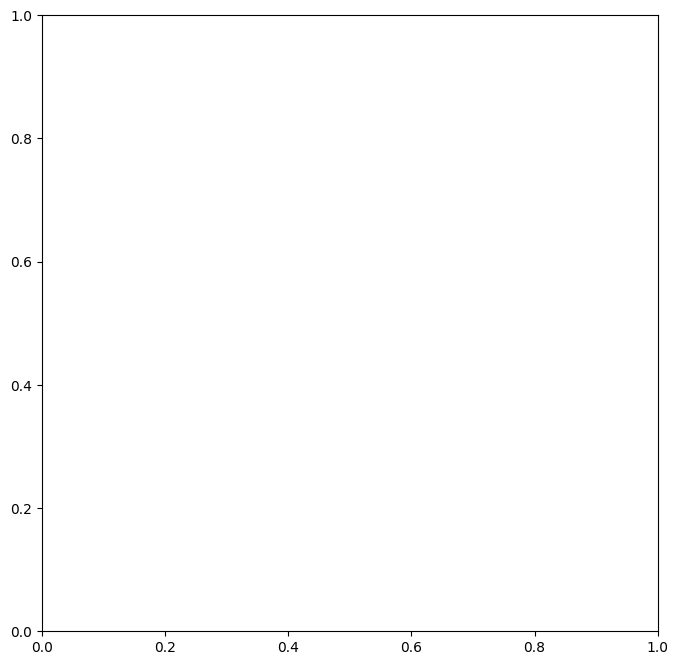

In [46]:
directory_path = 'data/clip'

display_tif_images(directory_path, cmap='hot')